# 멋진 단어사전 만들기 프로젝트

In [69]:
!pip install konlpy
!pip install sentencepiece
import tensorflow as tf
import numpy as np
import konlpy
import pandas as pd
import re
import sentencepiece as spm
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


## 함수

In [70]:
# 전처리 함수
def text_preprocessing(text):
    # 1. NaN 방지: 문자열 변환
    if pd.isnull(text):
        return ""

    # 2. 특수문자 제거 (한글, 영어->소문자, 숫자, 공백만 남김)
    text = re.sub(r"[^가-힣a-zA-Z0-9\s]", " ", text).lower()

    # 3. 연속 공백, 양쪽 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def sp_tokenize(s, corpus,padding):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=padding)

    return tensor, word_index, index_word

# history 확인용 그래프 함수
def show_history_graph(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # "bo"는 "파란색 점"입니다
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()



## 데이터 불러오기

In [71]:


# 파일 경로
file_path = 'data/ratings.txt'

# 데이터 불러오기
df_ori = pd.read_table(file_path)

df_ori.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## EDA

In [72]:
df = df_ori.copy()

print(f"전체 샘플 수: {len(df)}")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))  # 비율 확인

전체 샘플 수: 200000
label
1    100000
0    100000
Name: count, dtype: int64
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [73]:
# 중복 제거
df.drop_duplicates(subset=['document'], inplace=True)

# 결측치 제거
df.dropna(how = 'any', inplace=True)

print(f"전체 샘플 수: {len(df)}")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))  # 비율 확인

전체 샘플 수: 194543
label
0    97277
1    97266
Name: count, dtype: int64
label
0    0.500028
1    0.499972
Name: proportion, dtype: float64


---
### **완전하게 라벨 분포가 균형잡혀져 있는 이진 분류 셋이라는 것을 알 수 있음.**
학습할 때 클래스 불균형 문제는 발생하지 않을 것으로 예상된다.

---

count    194543.000000
mean         36.042345
std          29.497004
min           1.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         142.000000
Name: length, dtype: float64


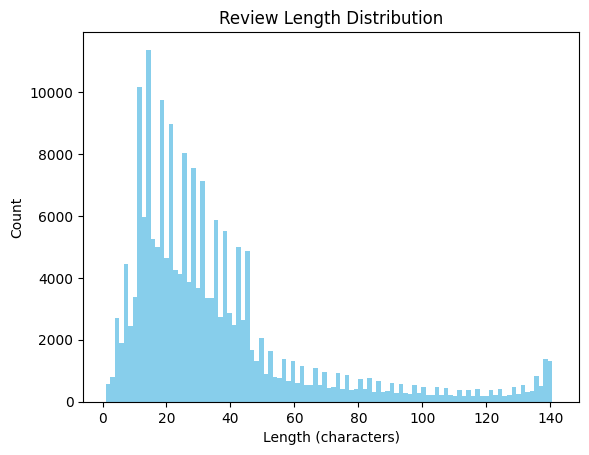

In [74]:


#모든 값을 다 문자열로 변환한다.
df['document'] = df['document'].astype(str)
df['length'] = df['document'].apply(len)

# 길이 통계
print(df['length'].describe())

# 시각화
import matplotlib.pyplot as plt

plt.hist(df['length'], bins=100, color='skyblue')
plt.title('Review Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

count    194543.000000
mean          7.760192
std           6.523433
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          42.000000
Name: pred_tok, dtype: float64


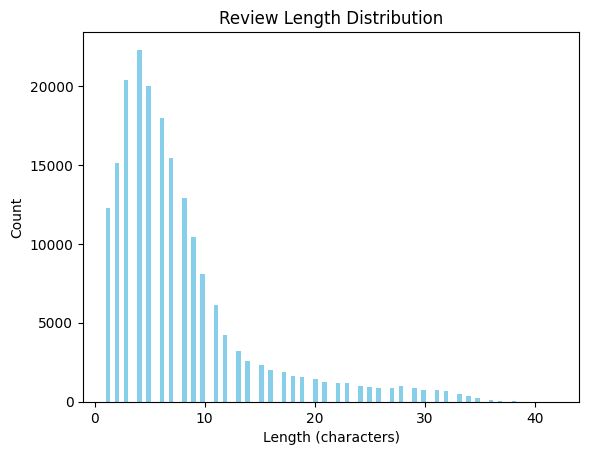

In [75]:
df['pred_tok'] = [len(s.split()) for s in df['document']]

# 길이 통계
print(df['pred_tok'].describe())

# 시각화
import matplotlib.pyplot as plt

plt.hist(df['pred_tok'], bins=100, color='skyblue')
plt.title('Review Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

In [76]:
# 짧은 리뷰 한번 어떻게 되어 있나 보기
short_reviews = df[df['pred_tok'] < 2]
print(short_reviews.sample(5, random_state=42))

              id           document  label  length  pred_tok
23025    8709799  정말집중해서잘봤어요.감동적이네요      1      17         1
133310   1142245      가슴만난잡하는너저분한영화      0      13         1
165010    521428             암울함...      0       6         1
63239   10045081      노래정말조아요ㅠㅠ!!!!      1      13         1
43912    4473328           ㅋㅋ와~쩐다쩌러      1       8         1


In [77]:
# 큰 리뷰 어떻게 되어 있나 보기
long_reviews = df[df['pred_tok'] > 35]
print(long_reviews.sample(5, random_state=42))

              id                                           document  label  \
104443   9854552  왠만하면 영화는 끝까지 다 보는데 끝까지 다 못 보겠더군요. 초반 한 시간만 제대로...      0   
8813    10025634  예전에 비디오 가게에서 빌려다 봤을 때는 많이 울었던 거 같은데 지금은 감성이 메말...      1   
73282    7495616  원 개훈남... 당레 입 닦아 주는 장면, 당레 트름 시켜 주는 장면, 미에트에게 ...      1   
52643    9755355  바 씬에서 아델과 엠마의 그 눈빛이 잊혀지지 않아요. 여자인 저도 반해버릴 것 같은...      1   
80913    8026574  작년에 못 봐서 이번에 다시보기로 정주행 했는데, 이렇게 완성도 있는 드라마가 왜 ...      1   

        length  pred_tok  
104443     139        37  
8813       140        37  
73282      140        38  
52643      139        36  
80913      140        36  


## 전처리

In [78]:

# 전처리 함수 적용
df['document'] = df['document'].astype(str).apply(text_preprocessing)

# 중복 제거
df.drop_duplicates(subset=['document'], inplace=True)

# 결측치 제거
df.dropna(how = 'any', inplace=True)


count    190719.000000
mean         33.881422
std          28.432176
min           0.000000
25%          15.000000
50%          25.000000
75%          40.000000
max         140.000000
Name: length, dtype: float64


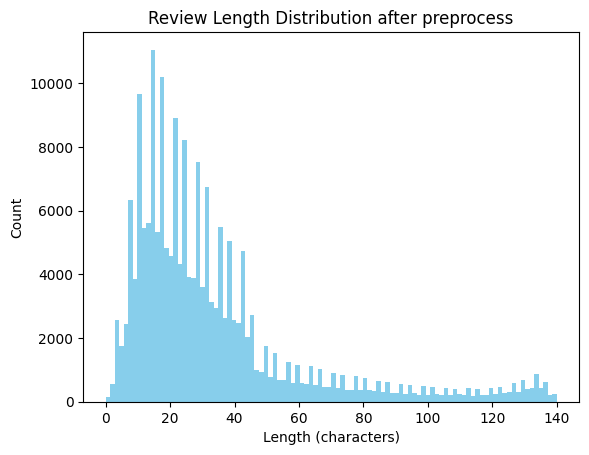

In [79]:
df['length'] = df['document'].apply(len)

# 길이 통계
print(df['length'].describe())

# 시각화
import matplotlib.pyplot as plt

plt.hist(df['length'], bins=100, color='skyblue')
plt.title('Review Length Distribution after preprocess')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

count    190719.000000
mean          8.072295
std           6.700545
min           0.000000
25%           4.000000
50%           6.000000
75%          10.000000
max          47.000000
Name: pred_tok, dtype: float64


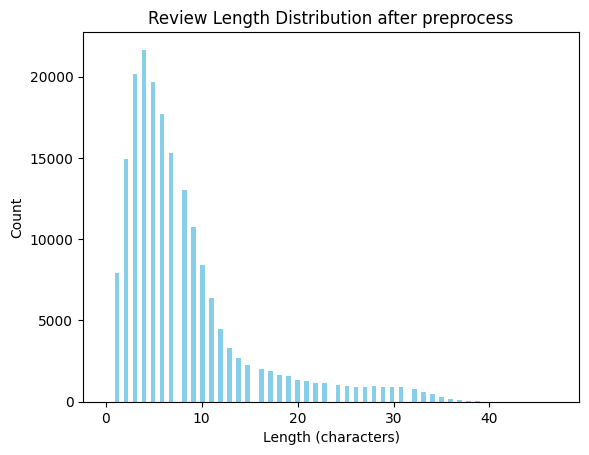

In [80]:
df['pred_tok'] = [len(s.split()) for s in df['document']]

# 길이 통계
print(df['pred_tok'].describe())

# 시각화
import matplotlib.pyplot as plt

plt.hist(df['pred_tok'], bins=100, color='skyblue')
plt.title('Review Length Distribution after preprocess')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

In [81]:
# 짧은 리뷰 한번 어떻게 되어 있나 보기
short_reviews = df[df['pred_tok'] < 2]
print(short_reviews.sample(5, random_state=42))


             id          document  label  length  pred_tok
60837   9760902         케이온3기나왔으면      1       9         1
128864   148254             기대했건만      0       5         1
103537  8384165  합채를탈락시키고정세운합격시켜나      0      16         1
75983   8572850    재밋엇는데평가가왤케이따구지      1      14         1
65795   7690116           감동실화라서더      1       7         1


In [82]:
# 큰 리뷰 어떻게 되어 있나 보기
long_reviews = df[df['pred_tok'] > 35]
print(long_reviews.sample(5, random_state=42))

              id                                           document  label  \
120361  10048126  이 영화에 10점 준 사람들은 정말 쥬라기 공원 1 보고 이 영화 보고 평점 준건가...      0   
24960    7067641  대선 직후에 이 영화를 보게 돼서 여운이 길게 남았습니다 사실 줄거리 자체만 놓고 ...      1   
116296   9583760  진심으로 이거 만든 예산이 아깝다 이 영화 감독은 전에 자기가 만든 공포영화처럼 화...      0   
103284   7847472  난 송새벽 연기가 싫음 애가 연기에 무슨 감정이 들어가 있는거 같지도 않고 분노 연...      0   
31749    8767658  평 생각이 없었는데 보고 나니 안할 수가 없네요 마지막에 결국 노예 무역 제도 폐지...      1   

        length  pred_tok  
120361     129        36  
24960      137        37  
116296     133        38  
103284     135        36  
31749      131        37  


In [83]:
MIN_LEN = 6
MAX_LEN = 130
MIN_TOK = 1
MAX_TOK = 35
# 전처리된 df에서 길이 필터링
df_final = df[(df['length'] >= MIN_LEN)
            & (df['pred_tok'] >= MIN_TOK)
            & (df['length'] <= MAX_LEN)
            & (df['pred_tok'] <= MAX_TOK)
          ].reset_index(drop=True)
print(f"필터링 전 리뷰 수: {len(df)}")
print(f"최종 리뷰 수: {len(df_final)}")

필터링 전 리뷰 수: 190719
최종 리뷰 수: 182469


In [84]:
# 클래스 불균형 일어났는지 확인해본다.

print("라벨 분포:")
print(df_final['label'].value_counts())

print("\n라벨 비율:")
print(df_final['label'].value_counts(normalize=True))

print("중복된 리뷰 수:", df_final.duplicated(subset=['document']).sum())

라벨 분포:
label
0    91273
1    91196
Name: count, dtype: int64

라벨 비율:
label
0    0.500211
1    0.499789
Name: proportion, dtype: float64
중복된 리뷰 수: 0


---
### 데이터 전처리는 잘되어진 것 같다.


---

## 실험

### SentencePiece model type = unigram, Vocab = 4000, padding = pre

In [85]:
!rm spm*

# -----------------------------
print("\n  학습용 SentencePiece 텍스트 파일 생성")
with open("spm_input.txt", "w") as f:
    for row in df_final['document']:
        f.write(row + "\n")



  학습용 SentencePiece 텍스트 파일 생성


In [86]:
print("\n  SentencePiece 모델 학습")
spm.SentencePieceTrainer.Train(
    input='spm_input.txt',
    model_prefix='spm',
    vocab_size=4000,
    model_type='unigram'
)



  SentencePiece 모델 학습


In [87]:
# -----------------------------
print("\n 토크나이저 로딩 확인")
s = spm.SentencePieceProcessor()
s.load("spm.model")

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))



 토크나이저 로딩 확인
[1645, 5, 360, 13, 1469, 5, 103, 10, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [88]:
print("\n 토큰화된 데이터 준비")
X,_,_ = sp_tokenize(s,df_final['document'],'pre')
y = df_final['label']


 토큰화된 데이터 준비


In [89]:
print("\n✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습")
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.2, random_state=42)

from tensorflow.keras import backend as K
K.clear_session()

model = Sequential([
    Embedding(input_dim=4000, output_dim=128, input_shape=(None,)),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)

# -----------------------------
print("\n✅ [Step 6] 최종 검증 정확도")
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ 최종 검증 정확도: {acc:.4f}")


✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7691 - loss: 0.4803 - val_accuracy: 0.8427 - val_loss: 0.3536
Epoch 2/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8545 - loss: 0.3416 - val_accuracy: 0.8474 - val_loss: 0.3401
Epoch 3/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8686 - loss: 0.3125 - val_accuracy: 0.8522 - val_loss: 0.3413
Epoch 4/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8846 - loss: 0.2815 - val_accuracy: 0.8496 - val_loss: 0.3392
Epoch 5/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8955 - loss: 0.2578 - val_accuracy: 0.8514 - val_loss: 0.3706

✅ [Step 6] 최종 검증 정확도
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8519 - loss: 0.3668
✅ 최종 검증 정확도: 0.8514


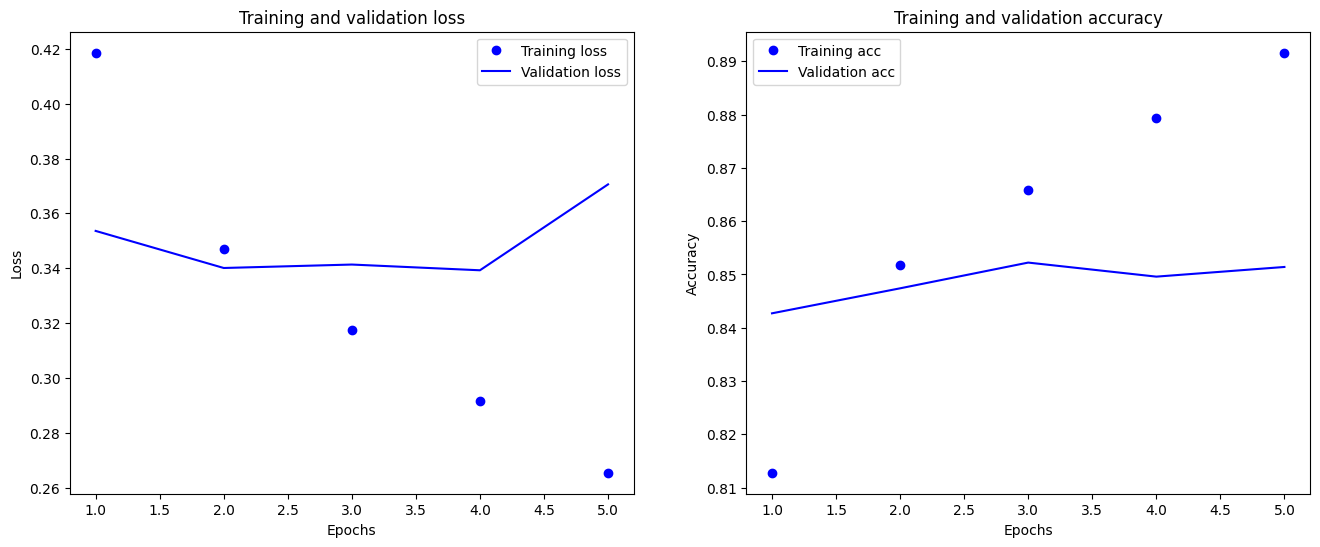

In [90]:
show_history_graph(history)

In [91]:
df_final.head()

,id,document,label,length,pred_tok
0,8112052,어릴때보고 지금다시봐도 재밌어요,1,17,3
1,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음 최고,1,33,8
2,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1,48,12
3,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1,26,8
4,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1,29,6


### SentencePiece model type = unigram, Vocab = 8000, padding = pre

In [92]:
!rm spm*

# -----------------------------
print("\n  학습용 SentencePiece 텍스트 파일 생성")
with open("spm_input.txt", "w") as f:
    for row in df_final['document']:
        f.write(row + "\n")



  학습용 SentencePiece 텍스트 파일 생성


In [93]:
print("\n  SentencePiece 모델 학습")
spm.SentencePieceTrainer.Train(
    input='spm_input.txt',
    model_prefix='spm',
    vocab_size=8000,
    model_type='unigram'
)



  SentencePiece 모델 학습


In [94]:
# -----------------------------
print("\n 토크나이저 로딩 확인")
s = spm.SentencePieceProcessor()
s.load("spm.model")

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))



 토크나이저 로딩 확인
[1263, 7, 396, 12, 1195, 7, 134, 13, 0]
['▁', '아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [95]:
print("\n 토큰화된 데이터 준비")
X,_,_ = sp_tokenize(s,df_final['document'],'pre')
y = df_final['label']


 토큰화된 데이터 준비


In [96]:
print("\n✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습")
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.2, random_state=42)

from tensorflow.keras import backend as K
K.clear_session()

model = Sequential([
    Embedding(input_dim=8000, output_dim=128, input_shape=(None,)),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)

# -----------------------------
print("\n✅ [Step 6] 최종 검증 정확도")
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ 최종 검증 정확도: {acc:.4f}")


✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7661 - loss: 0.4825 - val_accuracy: 0.8504 - val_loss: 0.3405
Epoch 2/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8694 - loss: 0.3117 - val_accuracy: 0.8554 - val_loss: 0.3317
Epoch 3/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8902 - loss: 0.2683 - val_accuracy: 0.8556 - val_loss: 0.3405
Epoch 4/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9107 - loss: 0.2265 - val_accuracy: 0.8524 - val_loss: 0.3743
Epoch 5/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9276 - loss: 0.1863 - val_accuracy: 0.8517 - val_loss: 0.4172

✅ [Step 6] 최종 검증 정확도
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8504 - loss: 0.4145
✅ 최종 검증 정확도: 0.8493


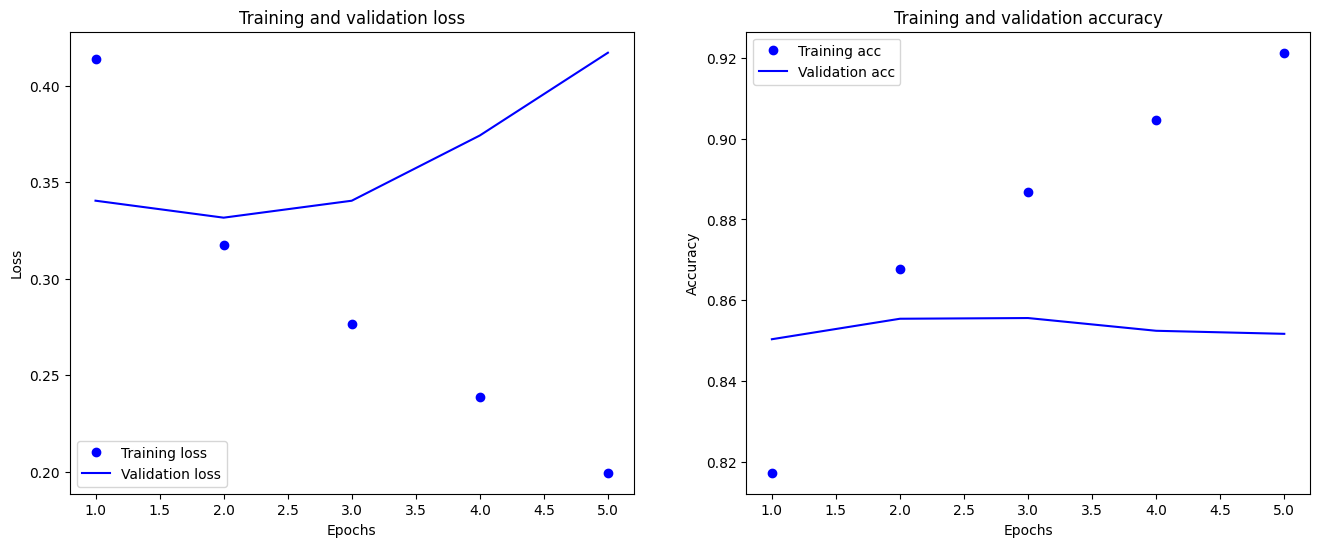

In [97]:
show_history_graph(history)

### SentencePiece model type = unigram, Vocab = 8000, padding = post

In [98]:
!rm spm*

# -----------------------------
print("\n  학습용 SentencePiece 텍스트 파일 생성")
with open("spm_input.txt", "w") as f:
    for row in df_final['document']:
        f.write(row + "\n")



  학습용 SentencePiece 텍스트 파일 생성


In [99]:
print("\n  SentencePiece 모델 학습")
spm.SentencePieceTrainer.Train(
    input='spm_input.txt',
    model_prefix='spm',
    vocab_size=8000,
    model_type='unigram'
)



  SentencePiece 모델 학습


In [100]:
# -----------------------------
print("\n 토크나이저 로딩 확인")
s = spm.SentencePieceProcessor()
s.load("spm.model")

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))



 토크나이저 로딩 확인
[1263, 7, 396, 12, 1195, 7, 134, 13, 0]
['▁', '아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [101]:
print("\n 토큰화된 데이터 준비")
X,_,_ = sp_tokenize(s,df_final['document'],'post')
y = df_final['label']


 토큰화된 데이터 준비


In [102]:
print("\n✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습")
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.2, random_state=42)

from tensorflow.keras import backend as K
K.clear_session()

model = Sequential([
    Embedding(input_dim=8000, output_dim=128, input_shape=(None,)),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)

# -----------------------------
print("\n✅ [Step 6] 최종 검증 정확도")
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ 최종 검증 정확도: {acc:.4f}")


✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습
Epoch 1/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.4977 - val_loss: 0.6931
Epoch 2/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 3/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 4/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.4977 - val_loss: 0.6932
Epoch 5/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.4977 - val_loss: 0.6932

✅ [Step 6] 최종 검증 정확도
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4979 - loss: 0.6932
✅ 최종 검증 정확도: 0.4992


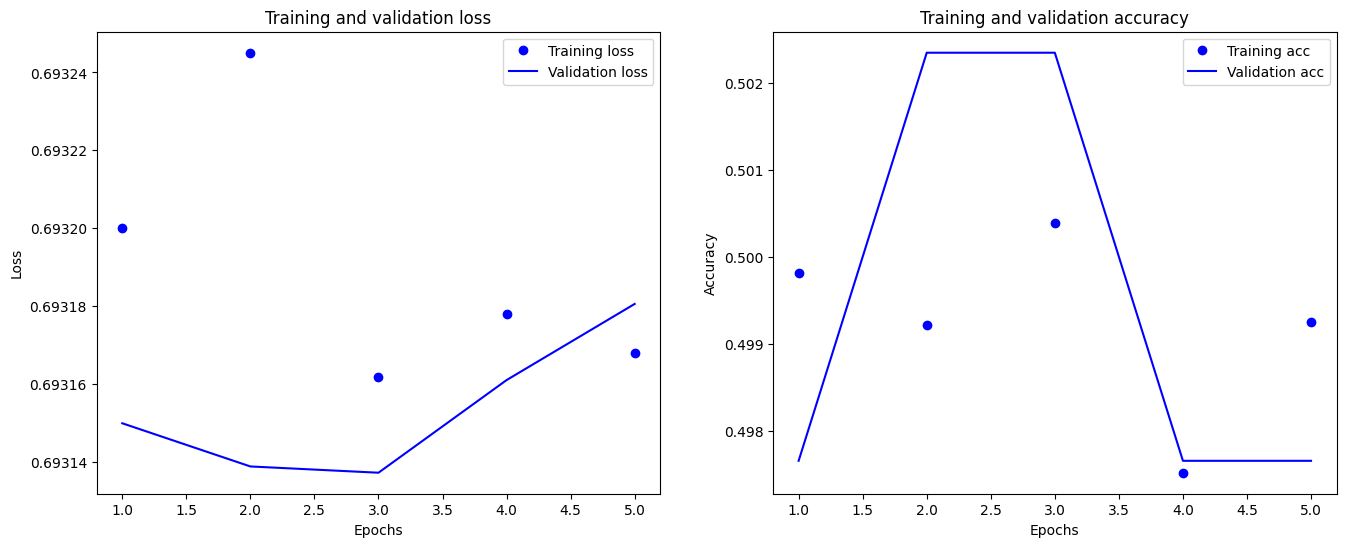

In [103]:
show_history_graph(history)

### SentencePiece model type = bpe, Vocab = 8000, padding = pre

In [110]:
!rm spm*

# -----------------------------
print("\n  학습용 SentencePiece 텍스트 파일 생성")
with open("spm_input.txt", "w") as f:
    for row in df_final['document']:
        f.write(row + "\n")



  학습용 SentencePiece 텍스트 파일 생성


In [111]:
print("\n  SentencePiece 모델 학습")
spm.SentencePieceTrainer.Train(
    input='spm_input.txt',
    model_prefix='spm',
    vocab_size=8000,
    model_type='bpe'
)



  SentencePiece 모델 학습


In [112]:
# -----------------------------
print("\n 토크나이저 로딩 확인")
s = spm.SentencePieceProcessor()
s.load("spm.model")

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))



 토크나이저 로딩 확인
[4667, 872, 6713, 6467, 1405, 6463, 6558, 6457, 0]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [113]:
print("\n 토큰화된 데이터 준비")
X,_,_ = sp_tokenize(s,df_final['document'],'pre')
y = df_final['label']


 토큰화된 데이터 준비


In [114]:
print("\n✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습")
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.2, random_state=42)

from tensorflow.keras import backend as K
K.clear_session()

model = Sequential([
    Embedding(input_dim=8000, output_dim=128, input_shape=(None,)),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)

# -----------------------------
print("\n✅ [Step 6] 최종 검증 정확도")
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ 최종 검증 정확도: {acc:.4f}")


✅ [Step 5] 학습/검증 데이터 분할 및 모델 학습
Epoch 1/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7602 - loss: 0.4865 - val_accuracy: 0.8497 - val_loss: 0.3388
Epoch 2/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8707 - loss: 0.3165 - val_accuracy: 0.8553 - val_loss: 0.3283
Epoch 3/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8937 - loss: 0.2684 - val_accuracy: 0.8532 - val_loss: 0.3354
Epoch 4/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9086 - loss: 0.2297 - val_accuracy: 0.8486 - val_loss: 0.3616
Epoch 5/5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9279 - loss: 0.1888 - val_accuracy: 0.8472 - val_loss: 0.3883

✅ [Step 6] 최종 검증 정확도
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8448 - loss: 0.3874
✅ 최종 검증 정확도: 0.8464


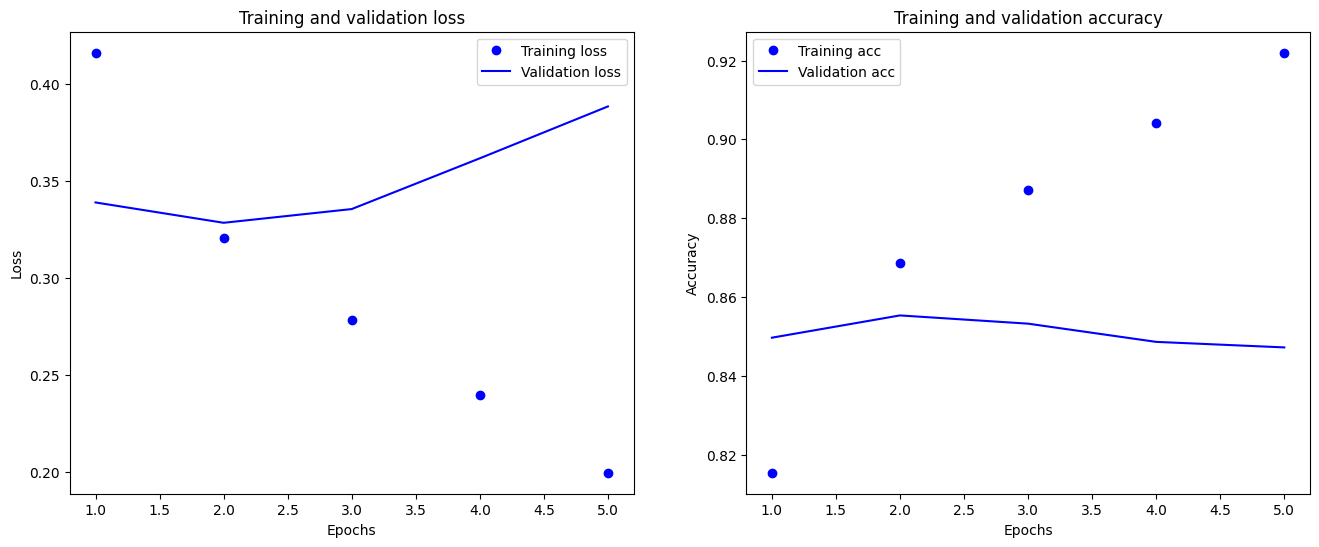

In [115]:
show_history_graph(history)

## 결론 및 회고

- vocab 사이즈는 적절한 값의 경우 잘 나오는거 같다. 위 실험에서는 작은 값의 결과가 좋았지만 vocab size를 키웠을때 더 좋은 결과가 나온 결과가 있었다.
- unigram과 bpe는 큰 차이가 없었다.
- padding 의 경우 pre 가 월등히 높은 성능을 보여줬으며 post의 경우 모델 특성때문인지 지나치게 낮은 정확도를 보였다.


도중에 LMS가 제대로 안되기도 하고, 테스트 결과가 지속적으로 accuracy 1로 나오는 등의 여러가지 문제가 있었다. 다행히 해결되어 어느정도 결론이 도출되었지만 생각했던 테스트들을 다 해보지 못한거 같아 아쉬움이 남는다. 현재 조합별로도 하나씩만 바꿔가며 테스트를 했는데 다른 조합이나 다른 토크나이저를 썼을때의 결과를 보지 못해 안타깝다.
